# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
data_path = "drive/MyDrive/Homeworks/credit_risk_dataset.csv"
df = pd.read_csv(data_path)

In [4]:
df.shape

(32581, 12)

In [5]:
df.iloc[:5]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [7]:
counts = df['loan_status'].value_counts()
percentages = df['loan_status'].value_counts(normalize=True) * 100

distribution = pd.DataFrame({'Counts': counts,'%': percentages.round(2)})
print(distribution)

             Counts      %
loan_status               
0             25473  78.18
1              7108  21.82


Imbalanced classification. Majority makes up 78%. If the model predicts 0 for everyone, it will achieve an accuracy of 78% creating the illusion of good performance. Minority makes up 21 % - critical segment as failing to identify a default costs the bank more than rejecting a reliable customer by mistake.


---

## Завдання 2: Дослідницький аналіз даних (EDA) (4 бали)

**Що потрібно зробити:**
1. Обчисліть відсоток пропущених значень в колонках. За наявності пропущених значень - заповніть їх медіаною для числових колонок і найбільш частим значеннмя для категоріальних.
2. Проаналізуйте розподіл числових змінних.
3. Знайдіть та обробіть викиди в колонці person_income з допомогою [Interquartile range](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D0%B6%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BC%D0%B0%D1%85).
4. Проаналізуйте категоріальні змінні відносно цільової та частоту зустрічання різних значень в них.
5. Візуалізуйте взаємозв'язок ознак з цільовою змінною.


In [8]:
missing_data = df.isnull().sum() / len(df) * 100
missing_data = missing_data.round(2)
print("Percentage of missing values:")
print(missing_data[missing_data > 0])

Percentage of missing values:
person_emp_length    2.75
loan_int_rate        9.56
dtype: float64


In [9]:
num_cols = df.select_dtypes(include=['number']).columns
for col in num_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

print("Remaining of missing values:")
print(df[['person_emp_length', 'loan_int_rate']].isnull().sum())

Remaining of missing values:
person_emp_length    0
loan_int_rate        0
dtype: int64


In [10]:
print(df.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       32581.000000  32581.000000   
mean      27.734600   6.607485e+04           4.767994   9589.371106   
std        6.348078   6.198312e+04           4.087372   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   32581.000000  32581.000000         32581.000000   
mean       11.009620      0.218164             0.170203   
std         3.081611      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         8.490000      0.000000             0.090000   
50%   

Issues detected:
*   Person-age: data over 100
*   Person_emp_length: length of work max number 123 which is impossible
*   Person_income: very large scale
*   Loan_status: mean value 0.218 inducates that 21.8% of borrowers default
*   Loan_percent_income: the average ratio of 0.17 means that 17% of income is used to cover loan payment, the max reaches 83% which is very risky and most likely will lead to default.









In [11]:
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

outliers = df[(df['person_income'] < lower_bound) | (df['person_income'] > upper_bound)]
print(f"Amount of detected outliers: {len(outliers)}")

Lower bound: -22550.0
Upper bound: 140250.0
Amount of detected outliers: 1484


In [12]:
df['person_income'] = np.where(df['person_income'] > upper_bound, upper_bound, df['person_income'])
df['person_income'] = np.where(df['person_income'] < lower_bound, lower_bound, df['person_income'])

print("New max income amount:", df['person_income'].max())

New max income amount: 140250.0


In [13]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [14]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for col in categorical_cols:
    pivot = df.groupby(col)['loan_status'].mean().sort_values(ascending=False) * 100
    print(f"\n% Default per category {col}:")
    print(pivot)


% Default per category person_home_ownership:
person_home_ownership
RENT        31.569987
OTHER       30.841121
MORTGAGE    12.570663
OWN          7.469040
Name: loan_status, dtype: float64

% Default per category loan_intent:
loan_intent
DEBTCONSOLIDATION    28.587874
MEDICAL              26.700708
HOMEIMPROVEMENT      26.102635
PERSONAL             19.887702
EDUCATION            17.216798
VENTURE              14.810282
Name: loan_status, dtype: float64

% Default per category loan_grade:
loan_grade
G    98.437500
F    70.539419
E    64.419087
D    59.045780
C    20.733973
B    16.275954
A     9.956389
Name: loan_status, dtype: float64

% Default per category cb_person_default_on_file:
cb_person_default_on_file
Y    37.806789
N    18.393203
Name: loan_status, dtype: float64


*   Majority of borrowers rent a property or have a mortgage. The % of homeowners is the smallest one.
*   Most popular intent - home improvement, medical and debt consolidation (28% - warning sign). People take loans due to financial issues and unpredictable circumstances.
*   The most common loan grades are G, F, E - almost guaranteed default.
*   Popele who have previously defaulted, default again in 37% of cases.




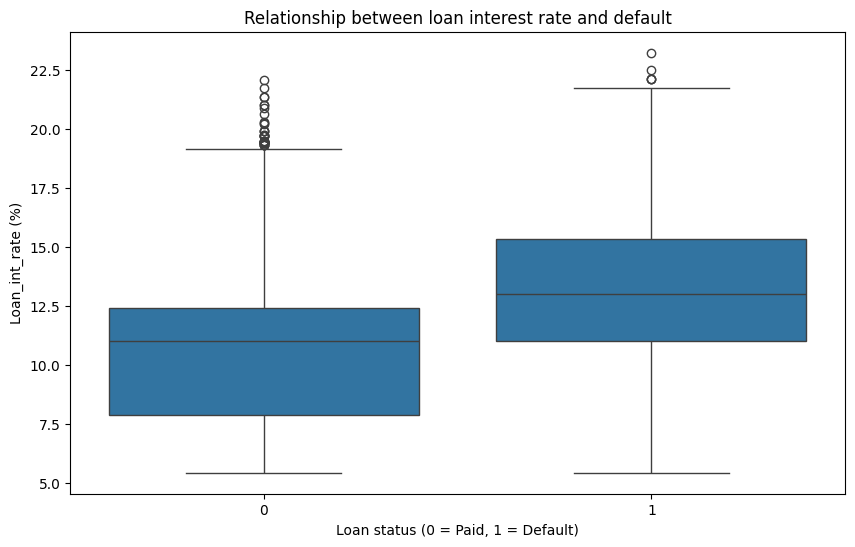

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_int_rate', data=df)
plt.title('Relationship between loan interest rate and default')
plt.xlabel('Loan status (0 = Paid, 1 = Default)')
plt.ylabel('Loan_int_rate (%)')
plt.show();

A higher interest rate is correlated with a higher risk of default.

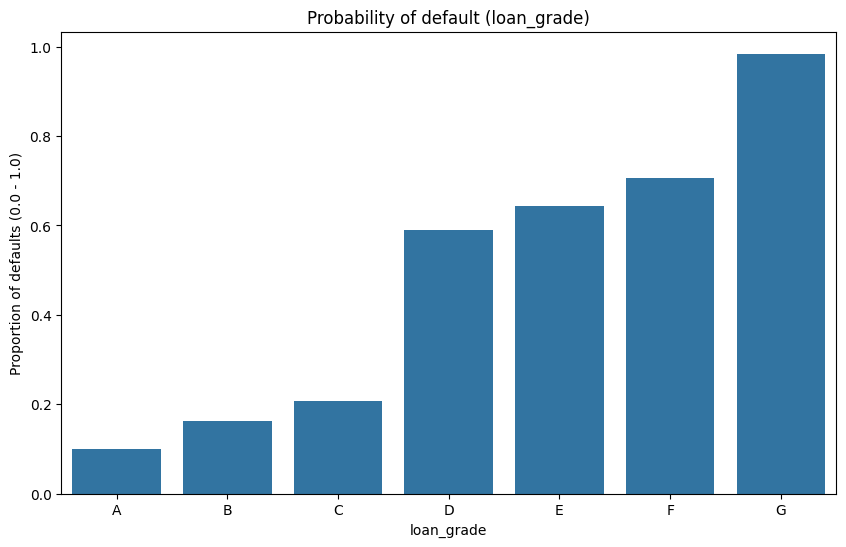

In [16]:
grade_risk = df.groupby('loan_grade')['loan_status'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='loan_grade', y='loan_status', data=grade_risk)
plt.title('Probability of default (loan_grade)')
plt.ylabel('Proportion of defaults (0.0 - 1.0)')
plt.show();


---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



In [17]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

fig = px.imshow(
    corr_matrix,
    text_auto='.2f',
    color_continuous_scale='RdBu_r',
    title="Correlation matrix",)

fig.update_layout(width=800, height=800)
fig.show();

In [18]:
from sklearn.preprocessing import LabelEncoder
df_final = df.copy()

le = LabelEncoder()
df_final['loan_grade'] = le.fit_transform(df_final['loan_grade'])

df_final = pd.get_dummies(df_final, columns=['person_home_ownership','loan_intent','cb_person_default_on_file'], drop_first=True)

X = df_final.drop(['loan_status', 'person_age'], axis=1)
y = df_final['loan_status']

X = X.astype(float)


---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Model successfully trained!")

Model successfully trained!


In [20]:
train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)

train_probs = model.predict_proba(X_train_scaled)[:, 1]
test_probs = model.predict_proba(X_test_scaled)[:, 1]

print("Predictions have been successfully generated for both datasets.")

Predictions have been successfully generated for both datasets.



---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, test_preds)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[4037 1058]
 [ 310 1112]]


In [22]:
import plotly.express as px
cm = confusion_matrix(y_test, test_preds)

labels = ['Paid (0)', 'Default (1)']

fig = px.imshow(
    cm,
    x=labels,
    y=labels,
    text_auto=True,
    color_continuous_scale='Blues',
    labels=dict(x="Predicted", y="Actual value", color="Count"),
    title="Confusion Matrix - TEST set")

fig.update_layout(xaxis_title="Predicted",yaxis_title="Actual",width=600,height=600)

fig.show();

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sets = [('Train', y_train, train_preds), ('Test', y_test, test_preds)]
results = []

for name, y_true, y_pred in sets:
    results.append({
        'Dataset': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)})

metrics_df = pd.DataFrame(results)
print(metrics_df)

  Dataset  Accuracy  Precision    Recall  F1-Score
0   Train  0.787216   0.508013  0.780514  0.615449
1    Test  0.790087   0.512442  0.781997  0.619154


In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Quality Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Model Quality Metrics:
Accuracy:  0.7901
Precision: 0.5124
Recall:    0.7820
F1-score:  0.6192


In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import plotly.graph_objects as go

fpr, tpr, thresholds = roc_curve(y_test, test_probs)
auc_value = roc_auc_score(y_test, test_probs)

fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'Logistic Regression (AUC = {auc_value:.3f})',line=dict(color='firebrick', width=3)))

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess',line=dict(dash='dash', color='grey')))

fig.update_layout(
    title='ROC-curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    height=600,
    template='plotly_white')

fig.show();

print(f"Calculated metric AUC: {auc_value:.4f}")

Calculated metric AUC: 0.8667


The result of 0.8667 shows that the model is good for bank scoring.

In [26]:
features = X.columns
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': features,'Coefficient': coefficients}).sort_values(by='Coefficient', ascending=True)

In [27]:
feature_importance

,Feature,Coefficient
8,person_home_ownership_OWN,-0.420167
3,loan_amnt,-0.408151
14,loan_intent_VENTURE,-0.405248
10,loan_intent_EDUCATION,-0.274892
0,person_income,-0.216935
13,loan_intent_PERSONAL,-0.162780
12,loan_intent_MEDICAL,-0.049655
4,loan_int_rate,-0.045746
15,cb_person_default_on_file_Y,-0.041967
6,cb_person_cred_hist_length,-0.007996


Positive coefficients (features increasing the risk of default): loan_percent_income (if people allocate most of their income to debt repayment, the risk of missed payment becomes critical), loan_grade (model relies on the assigned grades), person_home_ownership_RENT (renting a home is a risk comparing to owning).

Negative coefficients (features decresing the risk of default): person_home_ownership_OWN - owning a home is a strong reliability factor; loan_amnt - as it increases, the risk of default is descreasing (meaning that the bank grants large loans to throughly checked clients).


Overall, the model demostrates stable performance. AUC is 0.8667 meaning that the model has a strong ability to distinguish between reliable borrowers and defaulters. There is no Overfitting as the metrics on both training and test sets are pretty close. The model is good for catching most defaults (high recall - identifies correctly 78% of actual defaults).


---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.



In [28]:
thresholds = [0.2, 0.4, 0.5, 0.6, 0.8]
results = []

for t in thresholds:
    y_pred_t = (test_probs >= t).astype(int)

    results.append({'Threshold': t,'Precision': precision_score(y_test, y_pred_t),'Recall': recall_score(y_test, y_pred_t),'F1-Score': f1_score(y_test, y_pred_t)})

df_thresholds = pd.DataFrame(results)
print(df_thresholds)

   Threshold  Precision    Recall  F1-Score
0        0.2   0.325189  0.936006  0.482684
1        0.4   0.446131  0.847398  0.584526
2        0.5   0.512442  0.781997  0.619154
3        0.6   0.598125  0.718003  0.652605
4        0.8   0.757883  0.473277  0.582684


*  Threshold 0.2: recall 93% - almost all potential defaulters are detected;
                  precision 32% - every third person rejected would be really a defaulter
*  Threshold 0.6: F1-Score reaches its maximum - 0.65.
                  We still identify 71% of defaults, but the confidence in correctly rejecting risky applicants rises to 59%.
*  Threshold 0.8: recall 47% - missing more than half of the defaulting clients;
                  precision 75% - rejecting when we are alsmost certain of a default.






In [29]:
import plotly.graph_objects as go

all_thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for t in all_thresholds:
    y_p = (test_probs >= t).astype(int)
    precisions.append(precision_score(y_test, y_p, zero_division=0))
    recalls.append(recall_score(y_test, y_p))
    f1_scores.append(f1_score(y_test, y_p))

fig = go.Figure()
fig.add_trace(go.Scatter(x=all_thresholds, y=precisions, name='Precision', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=all_thresholds, y=recalls, name='Recall', line=dict(color='red')))
fig.add_trace(go.Scatter(x=all_thresholds, y=f1_scores, name='F1-Score', line=dict(color='green', dash='dash')))

fig.update_layout(title='Dependence of metrics on the classification threshold',xaxis_title='Threshold',yaxis_title= 'Metric value',hovermode='x unified')
fig.show();

My suggestion would be to chose a more conservative approach and go for 0.4 threshold as the number of detected defaulters is 84% in this case. Though it also has its disadvantage of rejecting good clients (precision 44%).


---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

dt_model = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

dt_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)

threshold = 0.4
lr_probs = model.predict_proba(X_test_scaled)[:, 1]
dt_probs = dt_model.predict_proba(X_test_scaled)[:, 1]
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

def get_metrics(y_true, probs, threshold):
    preds = (probs >= threshold).astype(int)
    return {
        'Precision': precision_score(y_true, preds),
        'Recall': recall_score(y_true, preds),
        'F1-Score': f1_score(y_true, preds),
        'ROC-AUC': roc_auc_score(y_true, probs)}

results = {
    'Logistic Regression': get_metrics(y_test, lr_probs, threshold),
    'Decision Tree': get_metrics(y_test, dt_probs, threshold),
    'Random Forest': get_metrics(y_test, rf_probs, threshold)}

results_df = pd.DataFrame(results).T
print(f"Results with a threshold of {threshold}:")
print(results_df.round(4))

Results with a threshold of 0.4:
                     Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.4461  0.8474    0.5845   0.8667
Decision Tree           0.7135  0.7672    0.7394   0.9091
Random Forest           0.9320  0.7321    0.8200   0.9314


The best result - Random Forest. Precision 93% indicating that if the model says it is a default, it is right in 93% of cases. Good clients are almost not being rejected.

However, if we are focusing on recall, the best option would be a logistic regression - it detects more defaults (84%) than other models.